In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 6.3 Identifying a stationary ARMA process 

ACF가 천천히 감쇠하거나 사인파 패턴을 나타내면 MA대신 AR을 사용할 수 있다.  
AR은 제기 자신에 대한 회귀모델이다.
MA, AR을 통해서 우리는 랜덤워크, MA, RA를 모델링할 수있는 단계에 이르렀다.   
다음 단계는 ACF나 PACF로 차수를 추론하기 어려운 모델을 처리하는 방법을 배운다.  
다시말해 ACF, PACF 모두 천천히 감쇠하는 패턴이나 사인파 패턴을 내는 경우를 말한다.   
이경우 RA, MA가 모두 존재하는 것이며 ARMA 모델을 사용한다.   
이 경우 ACF, PACF로 q, p의 차수를 결정할 수 없다. 두 플롯 모두 천천히 감쇠하거나 사인파 패턴을 나타내기 때문이다.   

따라서 우리는 복잡한 시계열을 모델을할 수 있는 일반적인 절차를 정의한다.   
여기에는 AIC를 사용한 p, q 조합 설정방법이 포함된다.  
이후 잔차를 분석하여 white noise와 유사한지 확인한다. 이때 qq플롯이나 density plot을 사용하여 평가

arma는 상수 C, yt-p의 과거 값, 시계열의 평균, 오차항의 선형조합으로 나타난다.

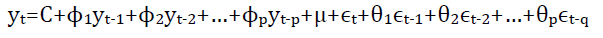

ACF와 PACF에서 유의미계수/ 비 유의미계수 사이에 경계선이 명확하지 않으면 ARMA 프로세스가 필요할 수 있음   


이를 실험하기 위해 시뮬레이션 해보자.  다음 식을 만들어보자.  
yt = 0.33yt-1 + 0.9et-1 +et

In [2]:
np.random.seed(42)

ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

In [3]:
ADF_result = adfuller(ARMA_1_1)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -6.42987868204269
p-value: 1.7078466680096923e-08


- 데이터는 stationary하다.

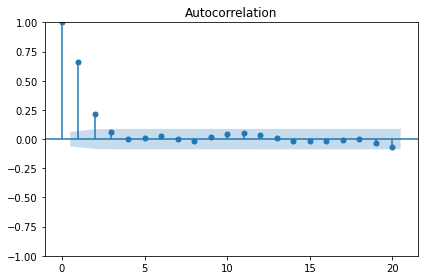

In [4]:
plot_acf(ARMA_1_1, lags=20);

plt.tight_layout()

plt.savefig('figures/CH06_F05_peixeiro.png', dpi=300)

- 사인파 형태를 볼수 있다. 따라서 AR 프로세스가 포함되었다고 볼수 있다.  
- 중요 coeff는 2이다. ...그런데 알다시피 AR(1)이다. 따라서 이 방법으로 q를 추정할 수 없다...

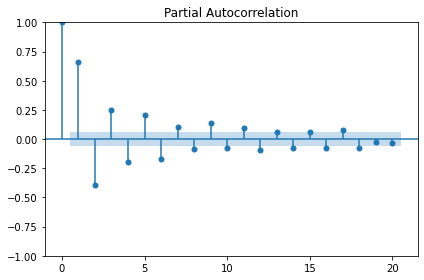

In [5]:
plot_pacf(ARMA_1_1, lags=20);

plt.tight_layout()

plt.savefig('figures/CH06_F06_peixeiro.png', dpi=300)

- 사인파 패턴 확인가능하고 명백한 cut-off가 없다.  
- PACF로 ARMA의 p를 추정할 수 없다는 뜻이다.

시뮬레이션 결과에 따르면 ARMA 프로세스는 ACF, PACF에서 모두 사인파 패턴을 보여줬다.  
그러나 ARMA의 p, q는 식별되지 못했다.

따라서 최적의 p, q 조합을 찾는 방법을 고안해야한다.

### 6.4.1 Selecting the best model 

앞에서 ARMA 프로세스는 ACF, PACF에서 모두 사인파 또는 감쇠 패턴을 보이는 것을 확인했다.   
그리고 두 플롯모두 파라미터를 찾는데 유용하지 못했다.

다만 ARMA 프로세스는 ACF, PACF에서 모두 사인파 또는 감쇠패턴을 보여주므로 이를 통해 감지는 할 수 있다.

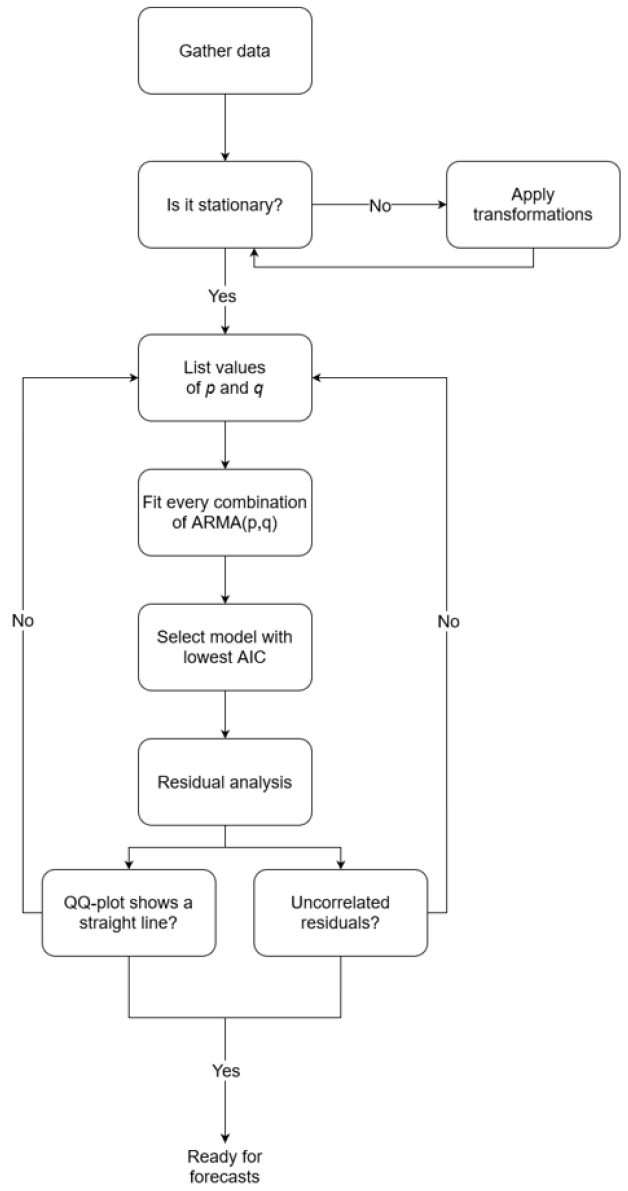

이제 우리는 p, q를 찾는 방법을 고안해야 한다. 이 방법은 nonstationary, seasonal pattern이 있는 경우에도 적용할 수 있다는 장점이 있다.

초기 단계는 5장까지 진행했던 것과 유사하다.   
그다음 arma를 적용하는 것이 낫겠다고 판단되면,
p,q 경우의 수를 나열한다.  

그다음 AIC를 계산한다.

그 다음 AIC가 가장 낮은 모델을 선택하고, 예측결과와 모델의 잔차를 분석한다.
이상적으로 잔차가 백색잡음처럼 보여야한다.

잔차는 상관관계가 없고, 독립적으로 분포되어야 한다.   
잔차는 qq플롯이다. Ljung box 테스트를 실행하여 속성을 평가한다.

분석결과 잔차가 랜덤이 나오면 모델을 사용할 수 있는 것이고,
없으면 다른 pq 조합을 시도해야 한다.

이 과정에서 새로운 기술들이 사용될 수 있다.

이제 AIC에 대해서 알아보자.  
모델링을 하면 일부 정보가 손실되는데, 이 손실된 양을 정량화 한 것이 AIC이다.

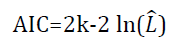

추정된 파라미터수 k는 p, q와 직접 연관이 있다.   
arma(2, 2) 이면 4개의 파라미터가 있다...   

복잡한 모델을 쓰면 차수가 높아지고, k증가 AIC가 증가하도록 되어있다.

이제 시뮬레이션된 arma(1, 1) 프로세스를 사용하여 모델링 절차를 다뤄보자.

앞에서도 실험했다시미 이 프로세스는 stationary

In [6]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs)) # itertools로 조합을 만든다
print(order_list)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


In [7]:
from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [8]:
ARMA_1_1.shape

(1000,)

In [9]:
result_df = optimize_ARMA(ARMA_1_1, order_list)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2805.932539
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


### 6.4.3 Performing residuals analysis 

이제 잔차로 모델의 품질을 결정한다.

잔차분석에는 정성적(qualitative) 분석과 정량적 분석 두가지가 존재한다.   
정성적 분석 : qq플롯  
정량적 분석 : 상관도 분석

#### Qualitative analysis: studying the Q-Q plot

정성적 분석 : quantile-quantile plot or Q-Q plot.    
qq플롯은 모델의 잔차가 정규분포를 따른다는 가설을 검증하는 도구이다.

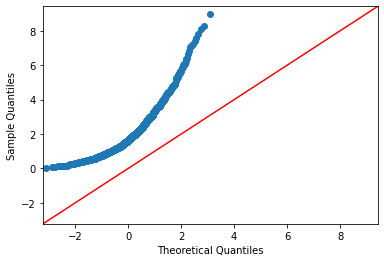

In [10]:
from statsmodels.graphics.gofplots import qqplot

gamma = np.random.default_rng().standard_gamma(shape=2, size=1000)

qqplot(gamma, line='45');

plt.savefig('figures/CH06_F11_peixeiro.png', dpi=300)

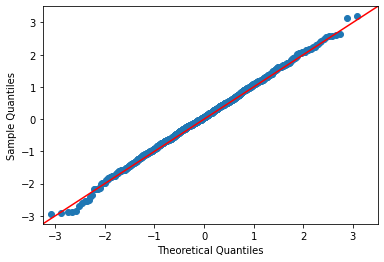

In [11]:
normal = np.random.normal(size=1000)

qqplot(normal, line='45');

plt.savefig('figures/CH06_F10_peixeiro.png', dpi=300)

qq플롯으로 잔차가 정규성을 따른다고 결정되면 Ljung-box 테스트를 적용하여 잔차가 상관관계가 없음을 입증할 수 있다.

### 6.4.4 Performing residuals analysis 

In [12]:
model = SARIMAX(ARMA_1_1, order=(1,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

- 이 모델로 잔차분석을 실시해보자.

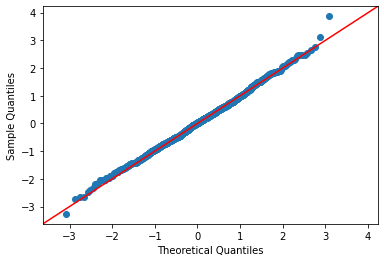

In [13]:
from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line='45');

plt.savefig('figures/CH06_F13_peixeiro.png', dpi=300)

정성적 분석의 확장  
아래도 정성적 분석이다.

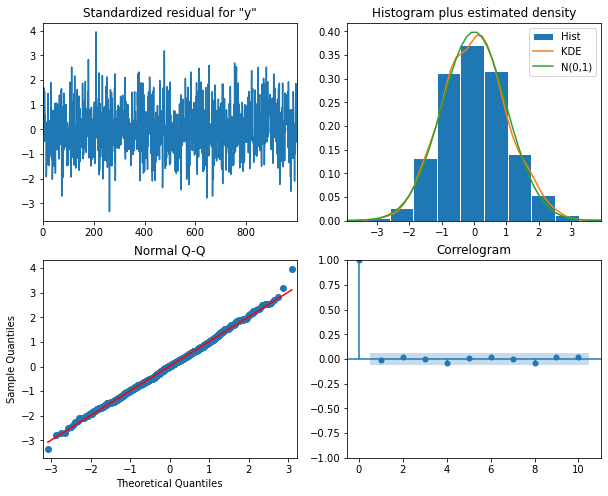

In [14]:
model_fit.plot_diagnostics(figsize=(10, 8));

plt.savefig('figures/CH06_F14_peixeiro.png', dpi=300)

In [15]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


## 6.5 Applying the general modeling procedure 

In [16]:
import pandas as pd

df = pd.read_csv('../data/bandwidth.csv')

df.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


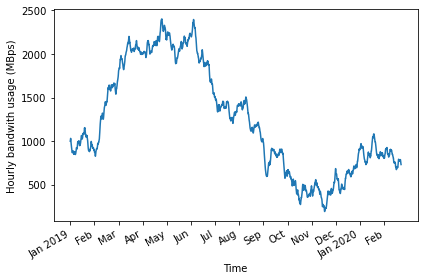

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH06_F02_peixeiro.png', dpi=300)

In [18]:
ADF_result = adfuller(df['hourly_bandwidth'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.8714653199452924
p-value: 0.7972240255014491


In [19]:
bandwidth_diff = np.diff(df.hourly_bandwidth, n=1)

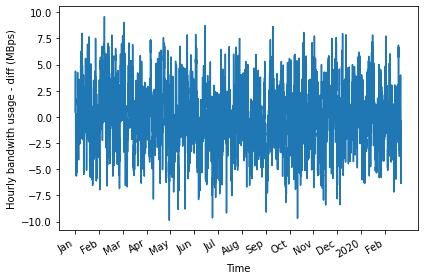

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(bandwidth_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage - diff (MBps)')

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/CH06_F_peixeiro.png', dpi=300)

In [21]:
ADF_result = adfuller(bandwidth_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -20.694853863789014
p-value: 0.0


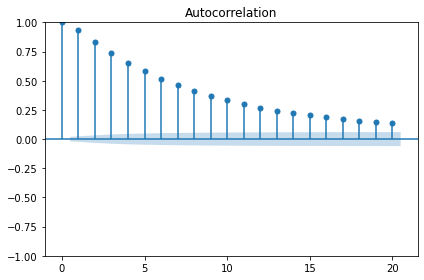

In [22]:
plot_acf(bandwidth_diff, lags=20);

plt.tight_layout()

# plt.savefig('figures/CH06_F_peixeiro.png', dpi=300)

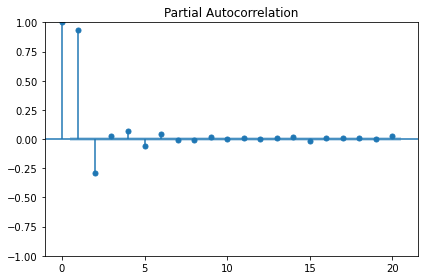

In [23]:
plot_pacf(bandwidth_diff, lags=20);

plt.tight_layout()

# plt.savefig('figures/CH06_F_peixeiro.png', dpi=300)

In [24]:
df_diff = pd.DataFrame({'bandwidth_diff': bandwidth_diff})

train = df_diff[:-168]
test = df_diff[-168:]

print(len(train))
print(len(test))

9831
168


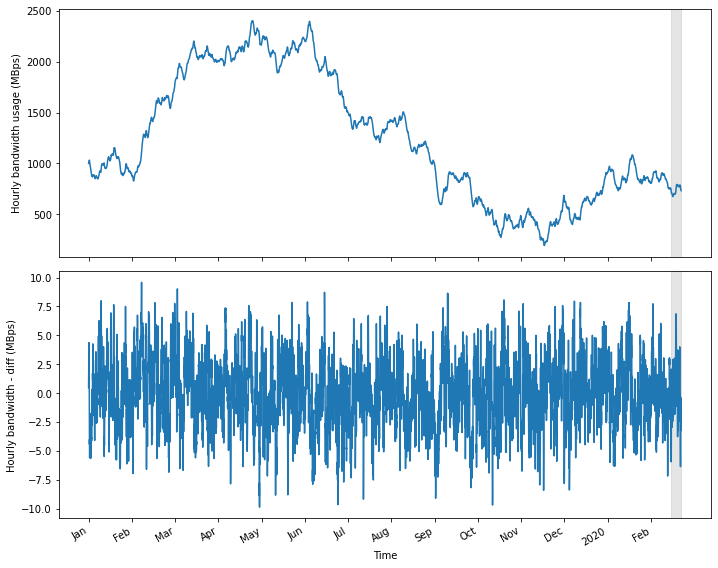

In [25]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(df['hourly_bandwidth'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Hourly bandwidth usage (MBps)')
ax1.axvspan(9831, 10000, color='#808080', alpha=0.2)

ax2.plot(df_diff['bandwidth_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Hourly bandwidth - diff (MBps)')
ax2.axvspan(9830, 9999, color='#808080', alpha=0.2)

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH06_F17_peixeiro.png', dpi=300)

In [26]:
from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [27]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))

In [28]:
result_df = optimize_ARMA(train['bandwidth_diff'], order_list)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 2)",27991.063879
1,"(2, 3)",27991.287509
2,"(2, 2)",27991.603598
3,"(3, 3)",27993.416924
4,"(1, 3)",28003.349550
5,"(1, 2)",28051.351401
6,"(3, 1)",28071.155496
7,"(3, 0)",28095.618186
8,"(2, 1)",28097.250766
9,"(2, 0)",28098.407664


In [29]:
model = SARIMAX(train['bandwidth_diff'], order=(2,0,2), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

# StackOverflow to save output as png

                               SARIMAX Results                                
Dep. Variable:         bandwidth_diff   No. Observations:                 9831
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -13990.802
Date:                Mon, 29 Aug 2022   AIC                          27991.604
Time:                        13:24:12   BIC                          28027.570
Sample:                             0   HQIC                         28003.788
                               - 9831                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3486      0.052      6.765      0.000       0.248       0.450
ar.L2          0.4743      0.047     10.000      0.000       0.381       0.567
ma.L1          0.8667      0.050     17.249      0.0

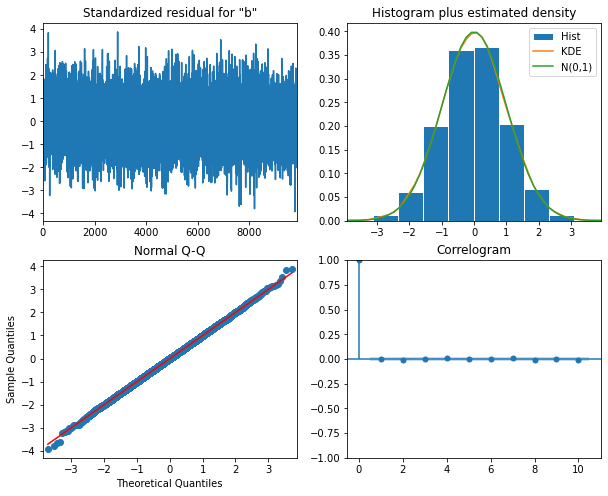

In [30]:
model_fit.plot_diagnostics(figsize=(10, 8));

plt.savefig('figures/CH06_F19_peixeiro.png', dpi=300)

In [31]:
residuals = model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


## 6.6 Forecasting bandwidth usage

In [32]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        return pred_ARMA

In [33]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2 #윈도우 사이즈를 2로 설정하여 rolling_mean이 평평하지 않도록 한다.

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.head()

,bandwidth_diff,pred_mean,pred_last_value,pred_ARMA
9831,-5.943995,-0.028214,-5.791207,-5.460661
9832,-5.865194,-0.028214,-5.791207,-4.890626
9833,-3.197066,-0.029410,-5.865194,-5.335905
9834,-1.090197,-0.029410,-5.865194,-4.751731
9835,0.665291,-0.029840,-1.090197,-0.375596


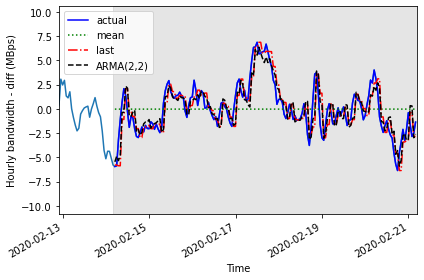

In [34]:
fig, ax = plt.subplots()

ax.plot(df_diff['bandwidth_diff'])
ax.plot(test['bandwidth_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(2,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth - diff (MBps)')

ax.axvspan(9830, 9999, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH06_F20_peixeiro.png', dpi=300)

In [35]:
mse_mean = mean_squared_error(test['bandwidth_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['bandwidth_diff'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['bandwidth_diff'], test['pred_ARMA'])

print(mse_mean, mse_last, mse_ARMA)

6.306526957989325 2.2297582947733656 1.7690462114091143


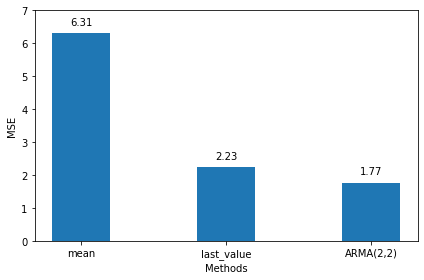

In [36]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'ARMA(2,2)']
y = [mse_mean, mse_last, mse_ARMA] 

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 7)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

# plt.savefig('figures/CH06_F_peixeiro.png', dpi=300)

In [37]:
df['pred_bandwidth'] = pd.Series()
df['pred_bandwidth'][9832:] = df['hourly_bandwidth'].iloc[9832] + test['pred_ARMA'].cumsum()

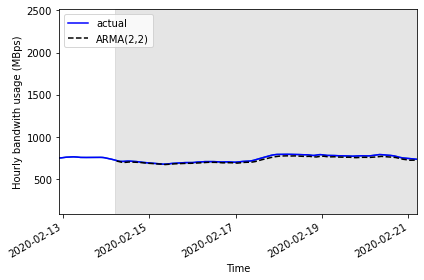

In [38]:
fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.plot(df['hourly_bandwidth'], 'b-', label='actual')
ax.plot(df['pred_bandwidth'], 'k--', label='ARMA(2,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

ax.axvspan(9831, 10000, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH06_F21_peixeiro.png', dpi=300)

In [39]:
mae_ARMA_undiff = mean_absolute_error(df['hourly_bandwidth'][9832:], df['pred_bandwidth'][9832:])

print(mae_ARMA_undiff)

14.000362776076614
